### Import Libraries

In [115]:
# Data processing
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_theme(style="whitegrid") # all charts will have a light grid
# from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist

# Deeo learning
import tensorflow as tf

# Text valuation/detection
import langid
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Text Preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
import spacy
from spacy import displacy
# Text stemming
from nltk.stem.porter import * 
# Text Vectorization
from tensorflow.keras.preprocessing.text import Tokenizer  
# padding sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

# model featuring
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History
from tensorflow.keras.models import load_model

# model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, SpatialDropout1D

# Analyze results
from sklearn.metrics import confusion_matrix
from keras.metrics import Precision, Recall

# Misc
import pickle
import os
import glob
import warnings
warnings.filterwarnings("ignore")
import datetime as dt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gumo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Gumo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [50]:
# read encoding of the file, so we can import it.
import chardet
with open('data_model/all-data.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

### Functions

In [63]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()

    wds =stopwords.words("english")
    wds.remove('not')
    # remove stopwords
    words = [w for w in words if w not in wds]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

# remove url
def remove_url(txt):
    return " ".join(re.sub("([-a-zA-Z0-9@:%_\+.~#?&//=]{2,256}\.[a-z]{2,4}\b(\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?)", "", txt).split())
#remove hashtag #
def remove_hashtag(txt):
    return " ".join(re.sub("([#]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)", "", txt).split())
# remove mention @
def remove_at(txt):
    return " ".join(re.sub("(\@[a-zA-Z0-9_%]*)", "", txt).split())

# remove stopwords and puncturations
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.remove('not')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])



# remove #, @, url, stopwords, punctuations, stemming
def removeFunc(a):
    x = remove_at(a)
    x = remove_hashtag(x)
    x = remove_url(x)
    x= get_text_processing(x.lower())
    return x

# Max length of review
def get_max_length(x):
    review_length = []
    for review in x:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

## Import Data/Cleaning

### Data Loading

In [29]:
df1 = pd.read_csv('data_model/Twitter_Data.csv')
df2 = pd.read_csv('data_model/apple-twitter-sentiment-texts.csv')
df3 = pd.read_csv('data_model/Reddit_Data.csv')
df4 = pd.read_csv('data_model/all-data.csv',encoding='Windows-1252',usecols=[0,1],names=['category','text'])

In [30]:
df1.head(1)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0


In [31]:
# rename columns
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
# change values
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df2.head(1)

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1.0


In [32]:
# rename columns
df3 = df3.rename(columns={'clean_comment': 'clean_text'})
# change values
df3['category'] = df3['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df3.head(1)

,clean_text,category
0,family mormon have never tried explain them t...,1.0


In [33]:
# rename columns
df4 = df4.rename(columns={'text': 'clean_text'})
# reorder columns
df4 = df4[['clean_text', 'category']]
# change values
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4.head(1)

,clean_text,category
0,"According to Gran , the company has no plans t...",0.0


In [34]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.shape

(206705, 2)

In [36]:
df.isnull().sum()

clean_text    104
category        7
dtype: int64

In [40]:
cleandf = df.dropna(axis=0)
cleandf.shape

(206594, 2)

In [41]:
cleandf.category.unique()

array([-1.,  0.,  1.])

In [42]:
cleandf = cleandf.rename(columns={'clean_text':'text','category': 'score'})
cleandf.head(1)

,text,score
0,when modi promised “minimum government maximum...,-1.0


In [43]:
cleandf.to_csv('data_model/merged_data.csv')

### Text Cleaning

In [48]:
df=pd.read_csv('data_model/merged_data.csv',index_col=0)

# create category column
df['category'] = df['score'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
df.head()

,text,score,category
0,when modi promised “minimum government maximum...,-1.0,Negative
1,talk all the nonsense and continue all the dra...,0.0,Neutral
2,what did just say vote for modi welcome bjp t...,1.0,Positive
3,asking his supporters prefix chowkidar their n...,1.0,Positive
4,answer who among these the most powerful world...,1.0,Positive


Text(0.5, 1.0, 'Sentiment Count')

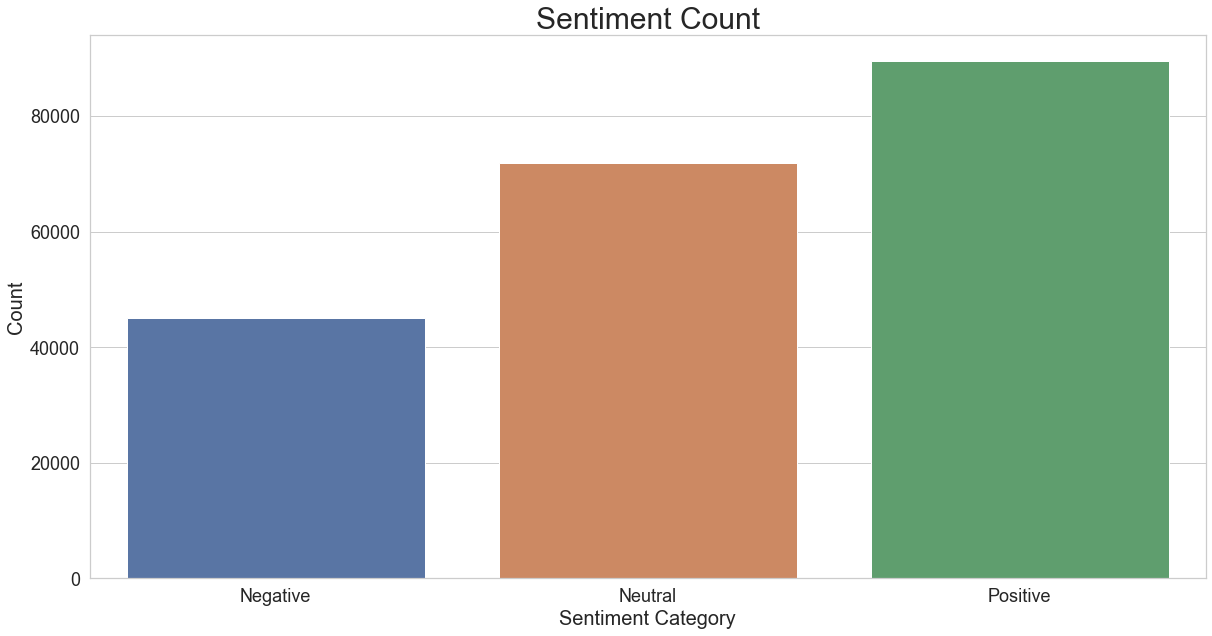

In [49]:
plt.figure(figsize=(20,10))
# set theme
sns.set_theme(style="whitegrid")
#countplot ploarity
sns.countplot(x=df.category)

plt.xlabel('Sentiment Category', fontsize=20)
plt.ylabel('Count', fontsize = 20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Sentiment Count', fontsize=30)

In [56]:
df2 = df.copy()
df2['filter_text'] = df.text.apply(removeFunc)
df2.head()

,text,score,category,filter_text
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...
1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...
4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...


In [61]:
df2['split_text'] = df2.filter_text.apply(tweet_to_words)
df2.head()

,text,score,category,filter_text,split_text
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...,"[modi, promis, minimum, govern, maximum, gover..."
1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi,"[talk, nonsens, continu, drama, vote, modi]"
2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...,"[say, vote, modi, welcom, bjp, told, rahul, ma..."
3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...,"[ask, support, prefix, chowkidar, name, modi, ..."
4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...,"[answer, among, power, world, leader, today, t..."


Text Vectorization

In [67]:
x_data = df2.split_text
y_data = pd.get_dummies(df2.category)
max_x_len = get_max_length(x_data)
max_x_len

16

In [73]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 

# find formula to vectorize the text
token.fit_on_texts(x_data)

# converting text into vector
x_token = token.texts_to_sequences(x_data)

### this is the code to add the pad to x_train
x_token_pad = pad_sequences(x_token, maxlen=max_x_len, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding

In [78]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(x_token_pad, y_data, test_size=0.25, random_state=42)

In [101]:
X_train.shape

(154945, 16)

In [102]:
y_train.shape

(154945, 3)

In [74]:
# saving to pickle file
with open('output/token_model1.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading from pickle file
with open('output/token_model1.pickle', 'rb') as handle:
    token = pickle.load(handle)

### Deep Learning

#### Embedding with LSTM

In [124]:
# ARCHITECTURE
EMBED_DIM = 32

#### add the model here:
lstm = Sequential()
# Embedding - common application is for text processing, changing integer into vectors
lstm.add(Embedding(total_words,EMBED_DIM,
                  input_length=max_x_len))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=81, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dropout(0.2))
lstm.add(Dense(27, activation='sigmoid'))
lstm.add(Dropout(0.2))
lstm.add(Dense(9, activation='sigmoid'))
lstm.add(Dropout(0.2))
lstm.add(Dense(3, activation='softmax'))

# show a graph of model
tf.keras.utils.plot_model(lstm, show_shapes=True)

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()
# Save model checkpoint and save best only
checkpoint = ModelCheckpoint('output/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)
# fit and train model, call back based on checkpoint(best model)
history = lstm.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 16, 32)            3611296   
                                                                 
 dropout_48 (Dropout)        (None, 16, 32)            0         
                                                                 
 lstm_20 (LSTM)              (None, 81)                36936     
                                                                 
 dropout_49 (Dropout)        (None, 81)                0         
                                                                 
 dense_32 (Dense)            (None, 27)                2214      
                                                                 
 dropout_50 (Dropout)  

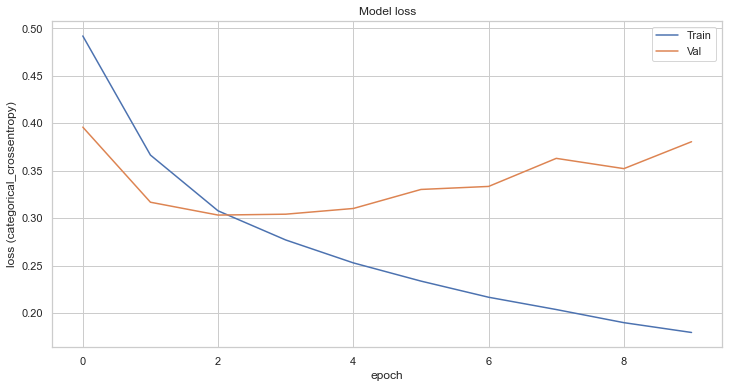

In [125]:
plt.figure(figsize=(12,6))
plt.plot(lstm.history.history['loss'][:])
plt.plot(lstm.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

#### Embedding, Conv1D with Bidirectional LSTM

In [117]:
#### add the model here:
model = Sequential()
model.add(Embedding(total_words,EMBED_DIM, input_length=max_x_len))
# Conv1D is for regression, Conv2D is for images, Conv3D
model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(pool_size=2))
# since maxpooling returns 3dimension, we dont need reshape, if we connect to regular NN, we should flatten to change shape into 2D
# model.add(Flatten)
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.2))
# dense 3 output is based on y dimension, this y dimension is (_, 3)
model.add(Dense(3, activation='softmax'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='softmax'))

# show a graph of model
tf.keras.utils.plot_model(model, show_shapes=True)

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 16, 32)            3611296   
                                                                 
 conv1d_9 (Conv1D)           (None, 16, 32)            3104      
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 16, 32)           0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 8, 32)            0         
 1D)                                                             
                                                                 
 bidirectional_9 (Bidir

In [119]:
# tensor board log
log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Save model checkpoint and save best only
checkpoint = ModelCheckpoint('output/convBiLSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)
# fit and train model, call back based on checkpoint(best model)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/10
2422/2422 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8052 - precision_2: 0.8196 - recall_2: 0.7892
Epoch 1: accuracy improved from -inf to 0.80517, saving model to output\convBiLSTM.h5
2422/2422 [==============================] - 105s 43ms/step - loss: 0.3294 - accuracy: 0.8052 - precision_2: 0.8196 - recall_2: 0.7892 - val_loss: 0.2967 - val_accuracy: 0.8141 - val_precision_2: 0.8260 - val_recall_2: 0.8030
Epoch 2/10
2422/2422 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.8422 - precision_2: 0.8553 - recall_2: 0.8281
Epoch 2: accuracy improved from 0.80517 to 0.84216, saving model to output\convBiLSTM.h5
2422/2422 [==============================] - 94s 39ms/step - loss: 0.2711 - accuracy: 0.8422 - precision_2: 0.8553 - recall_2: 0.8281 - val_loss: 0.2972 - val_accuracy: 0.8110 - val_precision_2: 0.8253 - val_recall_2: 0.7978
Epoch 3/10
2422/2422 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.870

In [120]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 2548), started 0:14:53 ago. (Use '!kill 2548' to kill it.)

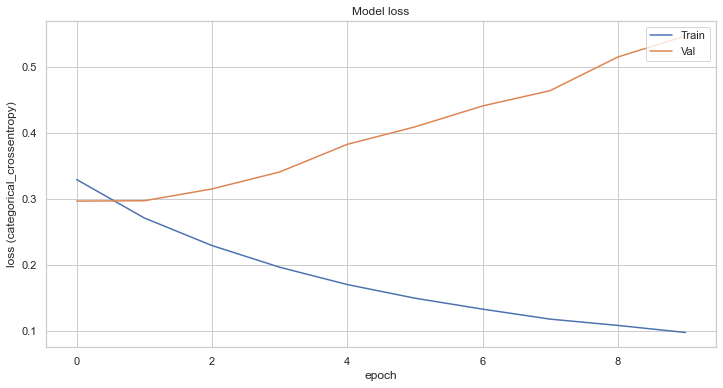

In [122]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')